# PCA

Principal Component Analysis (PCA) is basically a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, noise filtering, feature extraction & engineering, and much more.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

PCA is a fast and flexible unsupervised method for dimensionality reduction in data. It’s behaviour is easiest to visualize by looking at the two-dimensional dataset. Consider the following 300 points: 


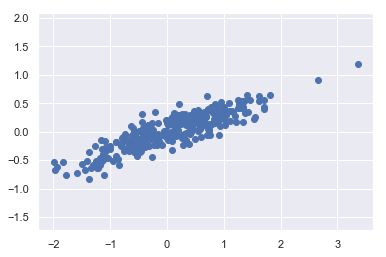

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 300)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

It is clear that there is a nearly linear relationship between x & y variables. In PCA, the relationship between x & y, is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset. Using Scikit-learn’s PCA estimator, we can compute this as follows:


In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":


In [5]:
print(pca.components_)

[[ 0.94625072  0.32343403]
 [-0.32343403  0.94625072]]


In [6]:
print(pca.explained_variance_)

[0.77935137 0.02004522]


To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:


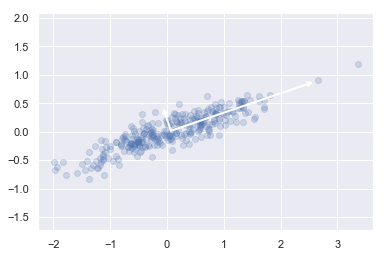

In [7]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the principal axes of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis. The projection of each data point onto the principal axes are the "principal components" of the data.

## Principal Component Analysis as  dimensionality reduction algo

PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform:


In [8]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (300, 2)
transformed shape: (300, 1)


The data now has been reduced to a single dimension. To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

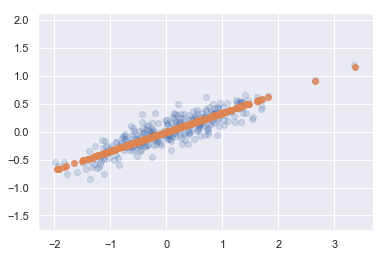

In [10]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version. This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance. The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.


### Let’s now move on to a high dimensional data, and see how PCA deals with the digits data.

We start by loading the data: 


In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The data consists of 8X8 pixel images, i.e. 64 dimensions. To gain some intuition into the relationship between these points, we can use PCA to project them to a more manageable number of dimensions i.e. 2


In [12]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


Let’s plot the first two components of each point to learn about the data:


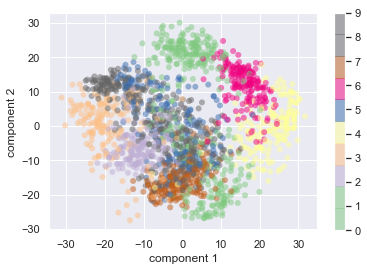

In [14]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();


The full data is a 64-D point cloud, and these points are the projection of each data point along with directions with the largest variance

### Choosing the number of components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:

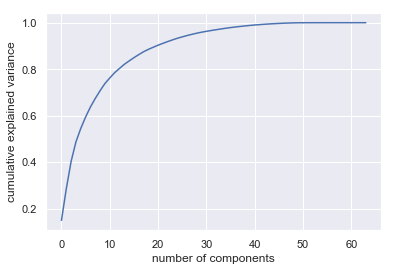

In [15]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 64-dimensional variance is contained within the first N components. For example, we see that with the digits of the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance. Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.


## PCA as Noise Filtering

PCA can also be used as a noise filtering technique. Any components with variance much larger than the effect of the noise should be relatively unaffected by the noise. So if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

Let's see how this looks with the digits data. First we will plot several of the input noise-free data:


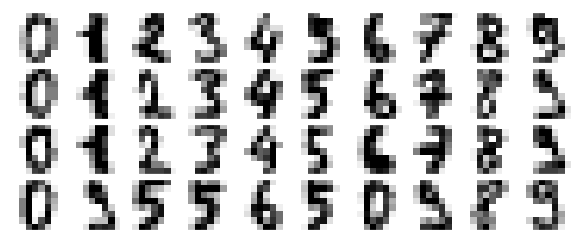

In [16]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Now let's add some random noise to create a noisy dataset, and re-plot it:
 

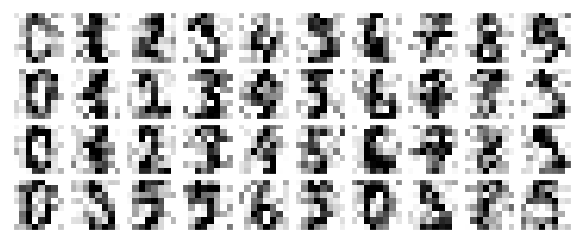

In [17]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

The images are noisy, and contain spurious pixels. 

Let's train a PCA on the noisy data, requesting that the projection preserve 50% of the variance:


In [18]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Here 50% of the variance amounts to 12 principal components. Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits:

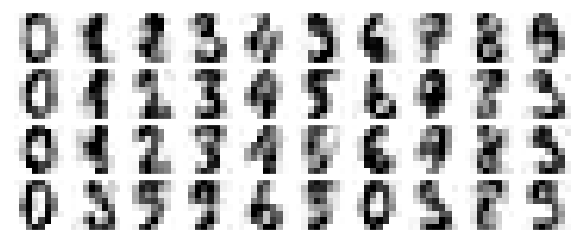

In [19]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

This signal preserving/noise filtering property makes PCA a very useful feature selection routine—for example, rather than training a classifier on very high-dimensional data, you might instead train the classifier on the lower-dimensional representation, which will automatically serve to filter out random noise in the inputs.